# EDA on Online Shopping in Retail Dataset

This notebook will focus on the Exploratory Data Analysis of the Online Shopping in Retail Dataset

### Necessary Imports

In [1]:
from db_utils import RDSDataBaseConnector
import pandas as pd
from transformations import DataTransform

### Loading in the Dataset

The customer_activity csv exctracted from the AWS RDS was previously extracted and saved locally. This has now been loaded in as a pandas dataframe to allow us to perform the relevant EDA techniques.

In [2]:
df=pd.read_csv('customer_activity.csv')




## Ensuring Columns are correct Datatype

Here there is some initial analysis on the dataframe columns datatype. I decided it was most appropriate to change the columns: ['administrative','product_related','month','operating_systems','browser','region','traffic_type','visitor_type'] to categorical data types. This is because they consist of only a few different string variables that are repeated and so using a categorical variable will save memory. For the columns: ['administrative_duration','informational_duration', 'product_related_duration'], I thought these were best changed to a timedelta64 datatype as they represent a duration of time a customer spent on a task. I made the assumption that all the values were in seconds as the data dictionary only specified this for 'informational_duration' .

In [3]:
import importlib
import transformations
importlib.reload(transformations)
from transformations import DataTransform
data_transformer_1=DataTransform()
columns_to_timdelta=data_transformer_1.convert_to_timedelta(df, columns=['administrative_duration', 'informational_duration', 'product_related_duration'])
columns_to_categrocial=data_transformer_1.convert_to_categorical(df, columns=['administrative', 'product_related', 'month', 'region', 'traffic_type', 'visitor_type'])
df.info()








<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   administrative            11760 non-null  category       
 1   administrative_duration   11418 non-null  timedelta64[ns]
 2   informational             12330 non-null  int64          
 3   informational_duration    11994 non-null  timedelta64[ns]
 4   product_related           11751 non-null  category       
 5   product_related_duration  12129 non-null  timedelta64[ns]
 6   bounce_rates              12330 non-null  float64        
 7   exit_rates                12330 non-null  float64        
 8   page_values               12330 non-null  float64        
 9   month                     12330 non-null  category       
 10  operating_systems         12319 non-null  object         
 11  browser                   12330 non-null  object         
 12  regi

## Nulls

This analysis attempts to identify any missing values in the data and subesquently replace them with the most appropriate value.

In [4]:

import importlib
import transformations
importlib.reload(transformations)
from transformations import DataFrameinfo,Plotter
data_informer=DataFrameinfo()
percentage_of_nulls=data_informer.percentage_nulls(df)
print(percentage_of_nulls)







administrative              0.046229
administrative_duration     0.073966
informational               0.000000
informational_duration      0.027251
product_related             0.046959
product_related_duration    0.016302
bounce_rates                0.000000
exit_rates                  0.000000
page_values                 0.000000
month                       0.000000
operating_systems           0.000892
browser                     0.000000
region                      0.000000
traffic_type                0.000000
visitor_type                0.000000
weekend                     0.000000
revenue                     0.000000
dtype: float64


We can see that there are 6 columns with missing values. The percentage of missing data is relatively small so we can impute the values using statistical methods such as the mean,median or mode imputation. In the case of ['administrative_duration],['informational_duration] and ['product_related_duration] I decided to use the median value of the columns for imputation. This is because using the median generally mitigates the effects of outliers as opposed to the mean. Whereas, for ['administrative'] and ['product_related'], I used the mode of these columns for imputation as these variables are categorical and so we cannot define a mean or median for them. In the case of the ['operating_systems] column, the proprtion of missing values is extremenly small(0.0892%), so it is proably best to just remove the rows with the null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   administrative            12330 non-null  category       
 1   administrative_duration   12330 non-null  timedelta64[ns]
 2   informational             12330 non-null  int64          
 3   informational_duration    12330 non-null  timedelta64[ns]
 4   product_related           12330 non-null  category       
 5   product_related_duration  12330 non-null  timedelta64[ns]
 6   bounce_rates              12330 non-null  float64        
 7   exit_rates                12330 non-null  float64        
 8   page_values               12330 non-null  float64        
 9   month                     12330 non-null  category       
 10  operating_systems         12319 non-null  object         
 11  browser                   12330 non-null  object         
 12  regi

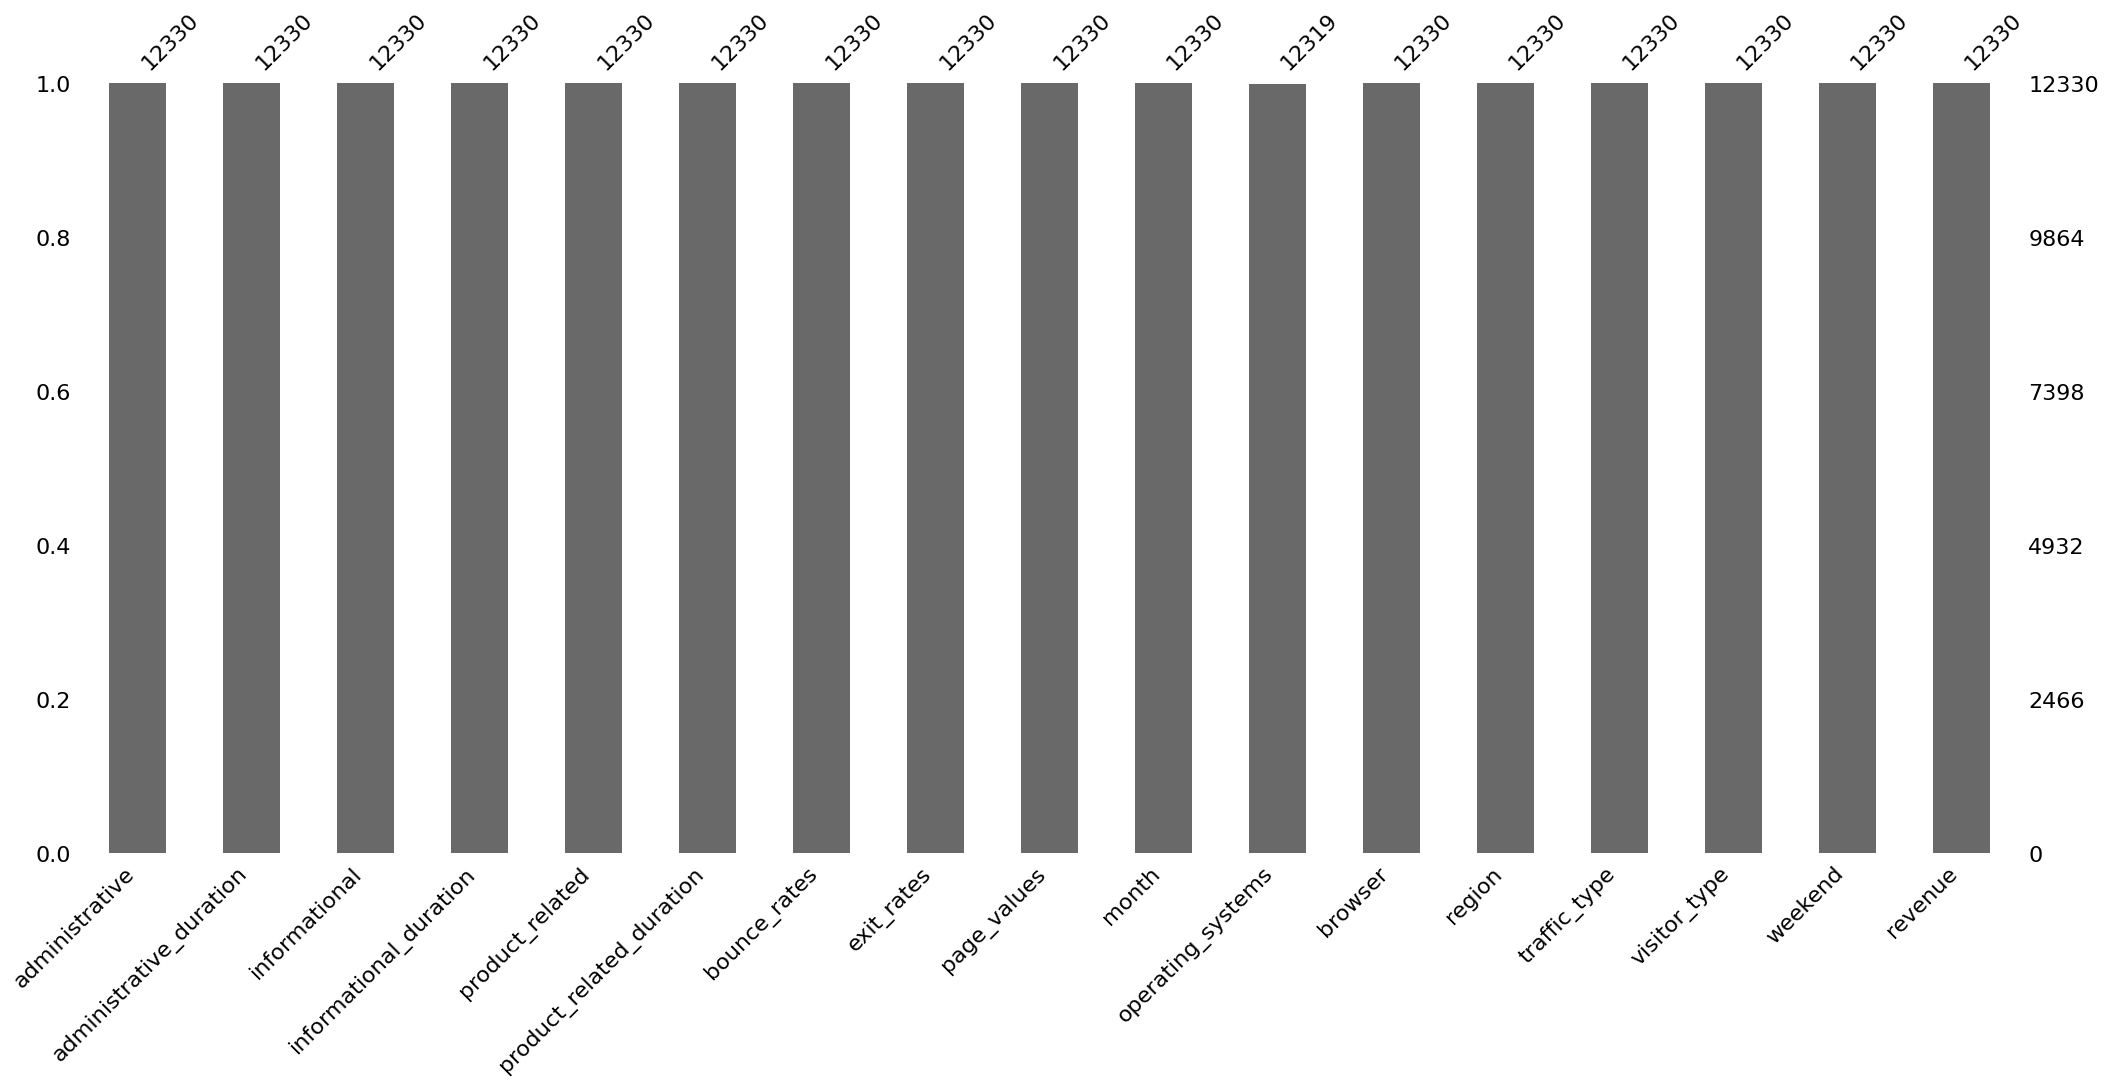

In [6]:
data_transformer_2=DataTransform()
drop_missing_rows=data_transformer_2.drop_rows(df,subset_column='operating_systems')
impute_nulls=data_transformer_2.impute_nulls(df)
plotter_1=Plotter()
visualise_nulls=plotter_1.generate_plot(df)
df.info()

## Skew

Skewed data is data that isn't symmetrically distributed around the mean and can lead to biased models and inaccurate results. This section will identify any skewed columns in the dataset and apply the appropriate transformations to handle them. We can use q-q plots and histograms, alongside the skew of the columns, in order to visualise the data distribution and determine a threshold over which a column will be considered skewed. We can then apply a skew transformation and subsequently replot the q-q plots and histrograms to see how the skeweness has been corrected.



informational    3.201809
page_values      6.023549
exit_rates       2.194420
bounce_rates     2.949097
dtype: float64


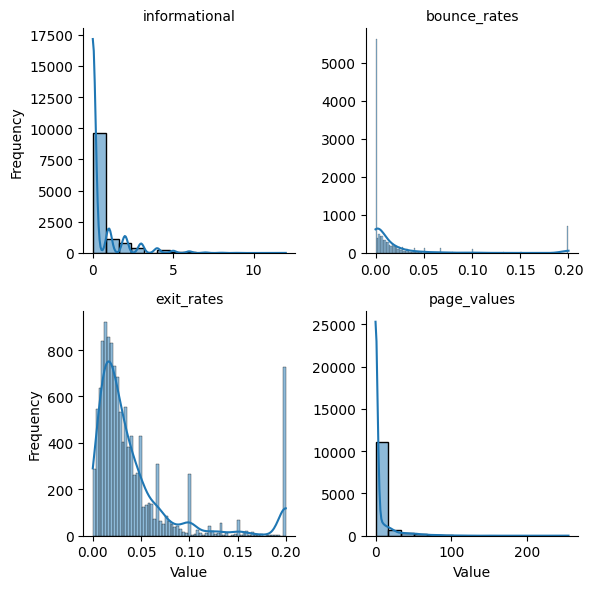

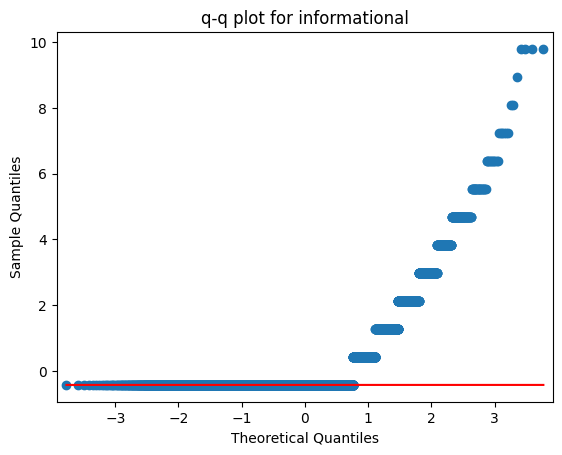

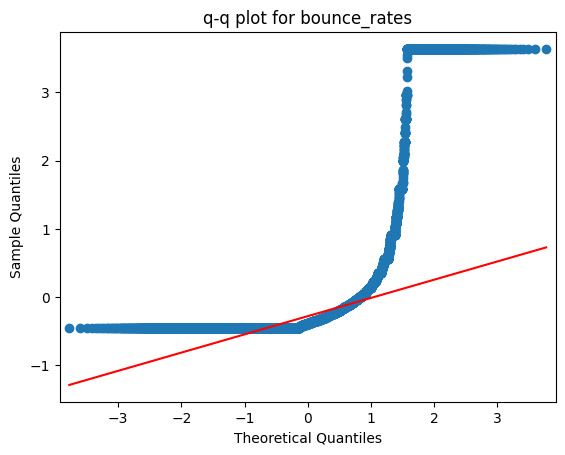

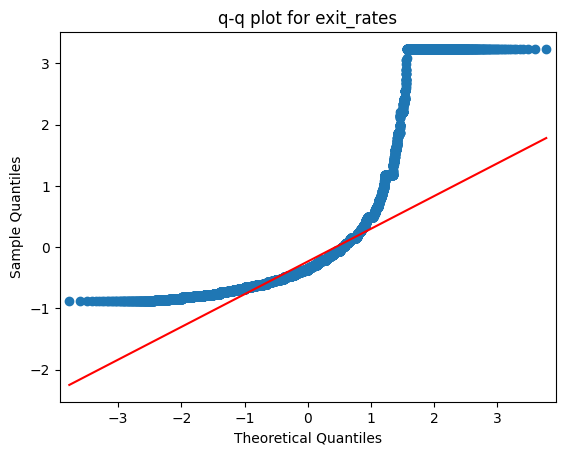

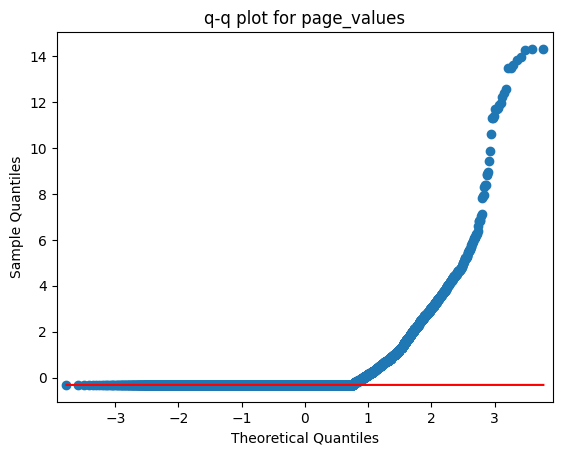

In [7]:
import importlib
import transformations
importlib.reload(transformations)
from transformations import Plotter
skewness=df.loc[:, ['informational', 'page_values', 'exit_rates', 'bounce_rates']].skew()
print(skewness)
plotter_2=Plotter()
plotter_2.create_histogram(df,columns=['informational','bounce_rates','exit_rates','page_values'])
plotter_2.create_qq_plot(df,columns=['informational','bounce_rates','exit_rates','page_values'])

The 4 columns shown above display significant skew from looking at their respective histograms and q-q plots. Before, we can correct this, it is a good idea to save a copy of the current dataset with the original values so we can use this for analysis later on. There are a few different methods that can be used to correct the skew in the data. After experimentation, I found that the Log transform was the best method to correct the skewness for the 'bounce_rates','exit_rates' and 'product_values' columns. However, for the 'informational' column, the Yeo-Johnson tranform made the biggest improvement to the skew value, so it was used for this case.

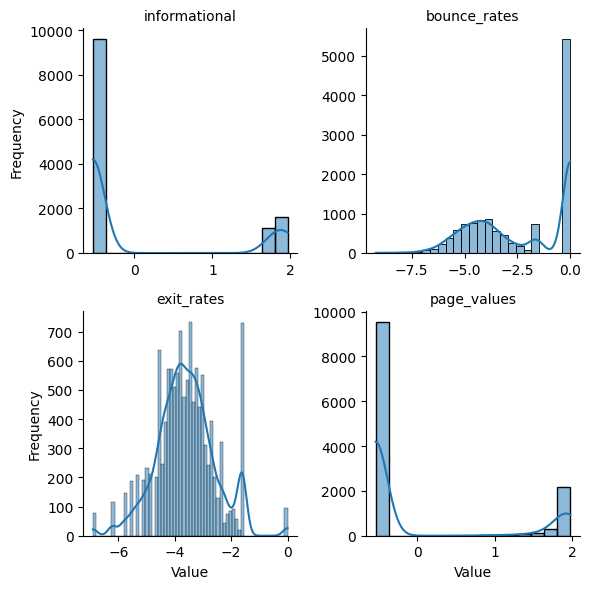

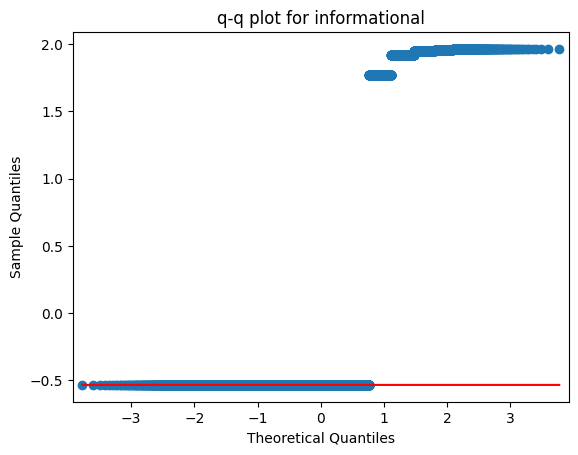

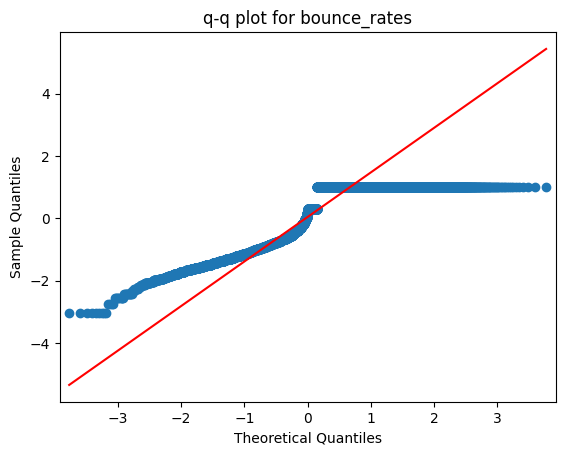

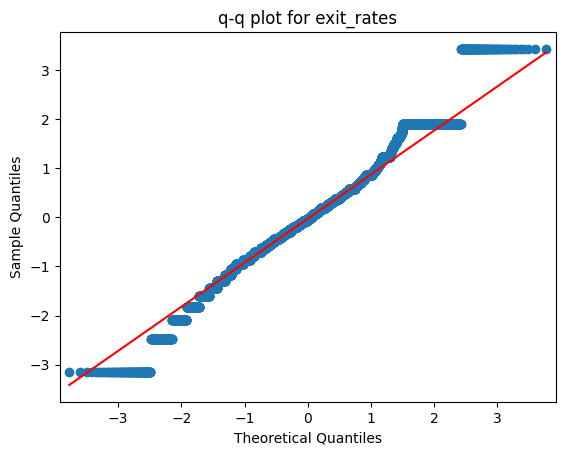

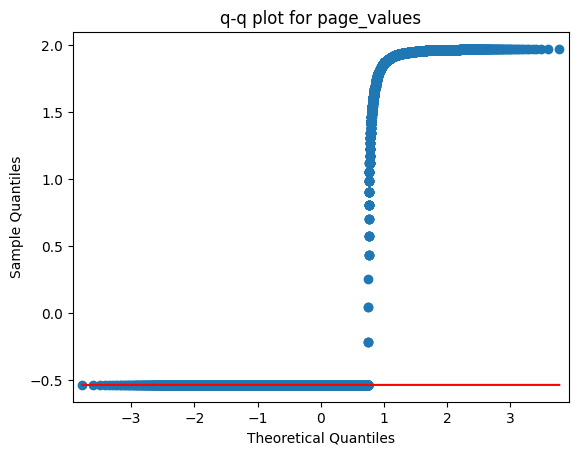

informational    1.344752
page_values      1.345110
exit_rates       0.126138
bounce_rates    -0.272768
dtype: float64

In [8]:
import importlib
import transformations
importlib.reload(transformations)
from transformations import DataTransform,Plotter
# save copy of original dataset as csv file
df.to_csv('modified_customer_activity.csv')
data_tranformer_3=DataTransform()
corrected_skew=data_tranformer_3.correct_skew(df,columns=['informational','bounce_rates','exit_rates','page_values'])
plotter_3=Plotter()
visualise_corrected_histograms=plotter_3.create_histogram(df,columns=['informational','bounce_rates','exit_rates','page_values'])
visualise_corrected_qqplots=plotter_3.create_qq_plot(df,columns=['informational','bounce_rates','exit_rates','page_values'])
df.loc[:, ['informational', 'page_values', 'exit_rates', 'bounce_rates']].skew()





## Outliers

Removing outliers from the dataset will improve the quality and accuracy of the analysis as outliers can distort the analysis results. This next stage will first identify and visualise the outliers uing boxplots. We can then use the (IQR) Interquartile range to determine which values should be removed. Any values that fall below the first quartile minus 1.5 times the IQR or the the third quartile plus 1.5 times the IQR are typically classified as outliers, as they lie outside the common range of variability in the data.

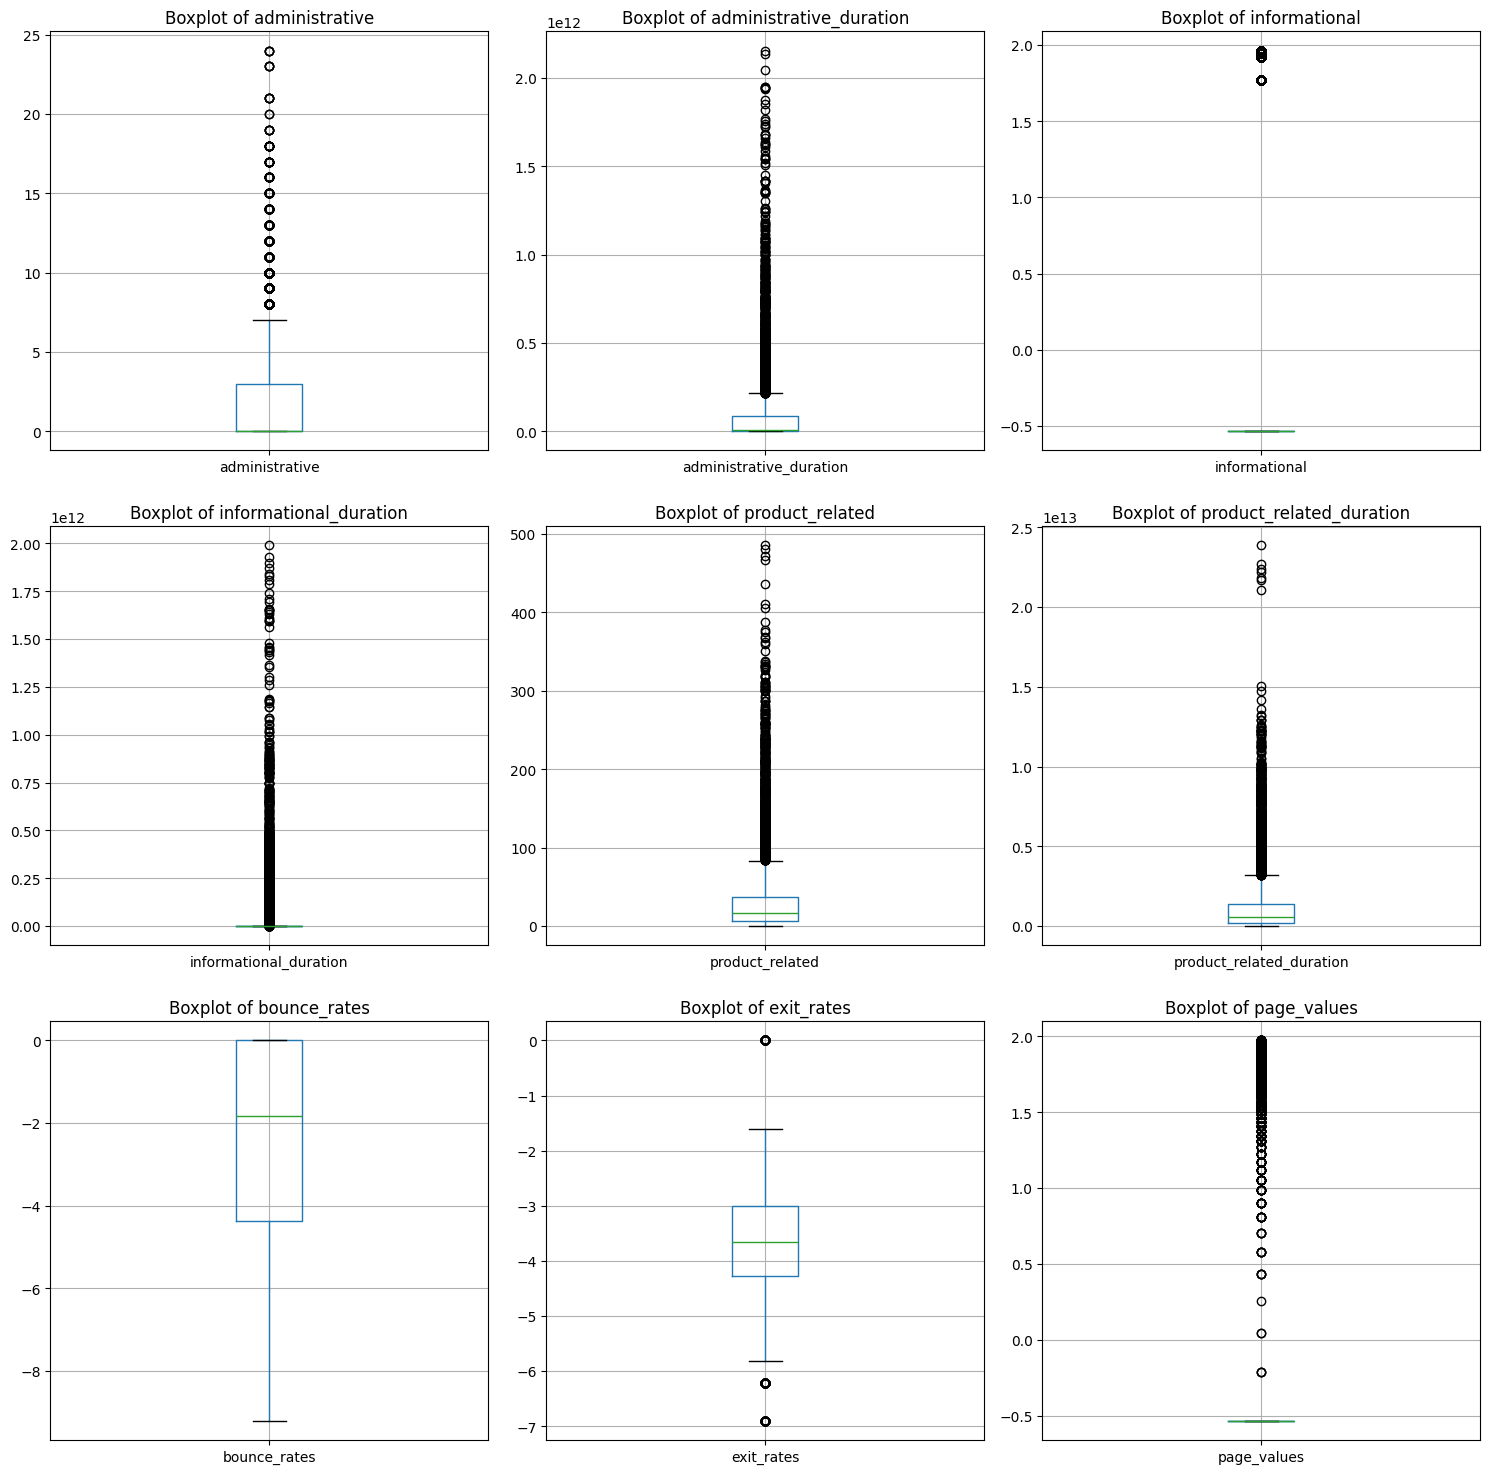

In [12]:
import importlib
import transformations
importlib.reload(transformations)
from transformations import DataTransform,Plotter
data_transformer_4=DataTransform()
convert_to_numerical=data_transformer_4.convert_to_numeric(df,columns=['administrative','administrative_duration','product_related','product_related_duration','informational_duration'])
plotter_4=Plotter()
visualise_outliers=plotter_4.visualise_outliers(df,columns=['administrative','administrative_duration','informational','informational_duration','product_related','product_related_duration','bounce_rates','exit_rates','page_values'])
data_transformer_5=DataTransform()
df_cleaned=data_transformer_5.remove_outliers(df, columns=['administrative','administrative_duration','informational','informational_duration','product_related','product_related_duration','bounce_rates','exit_rates','page_values'])


We can now re-visualise the cleaned data with the Plotter class to see if the outliers have been successfuly removed

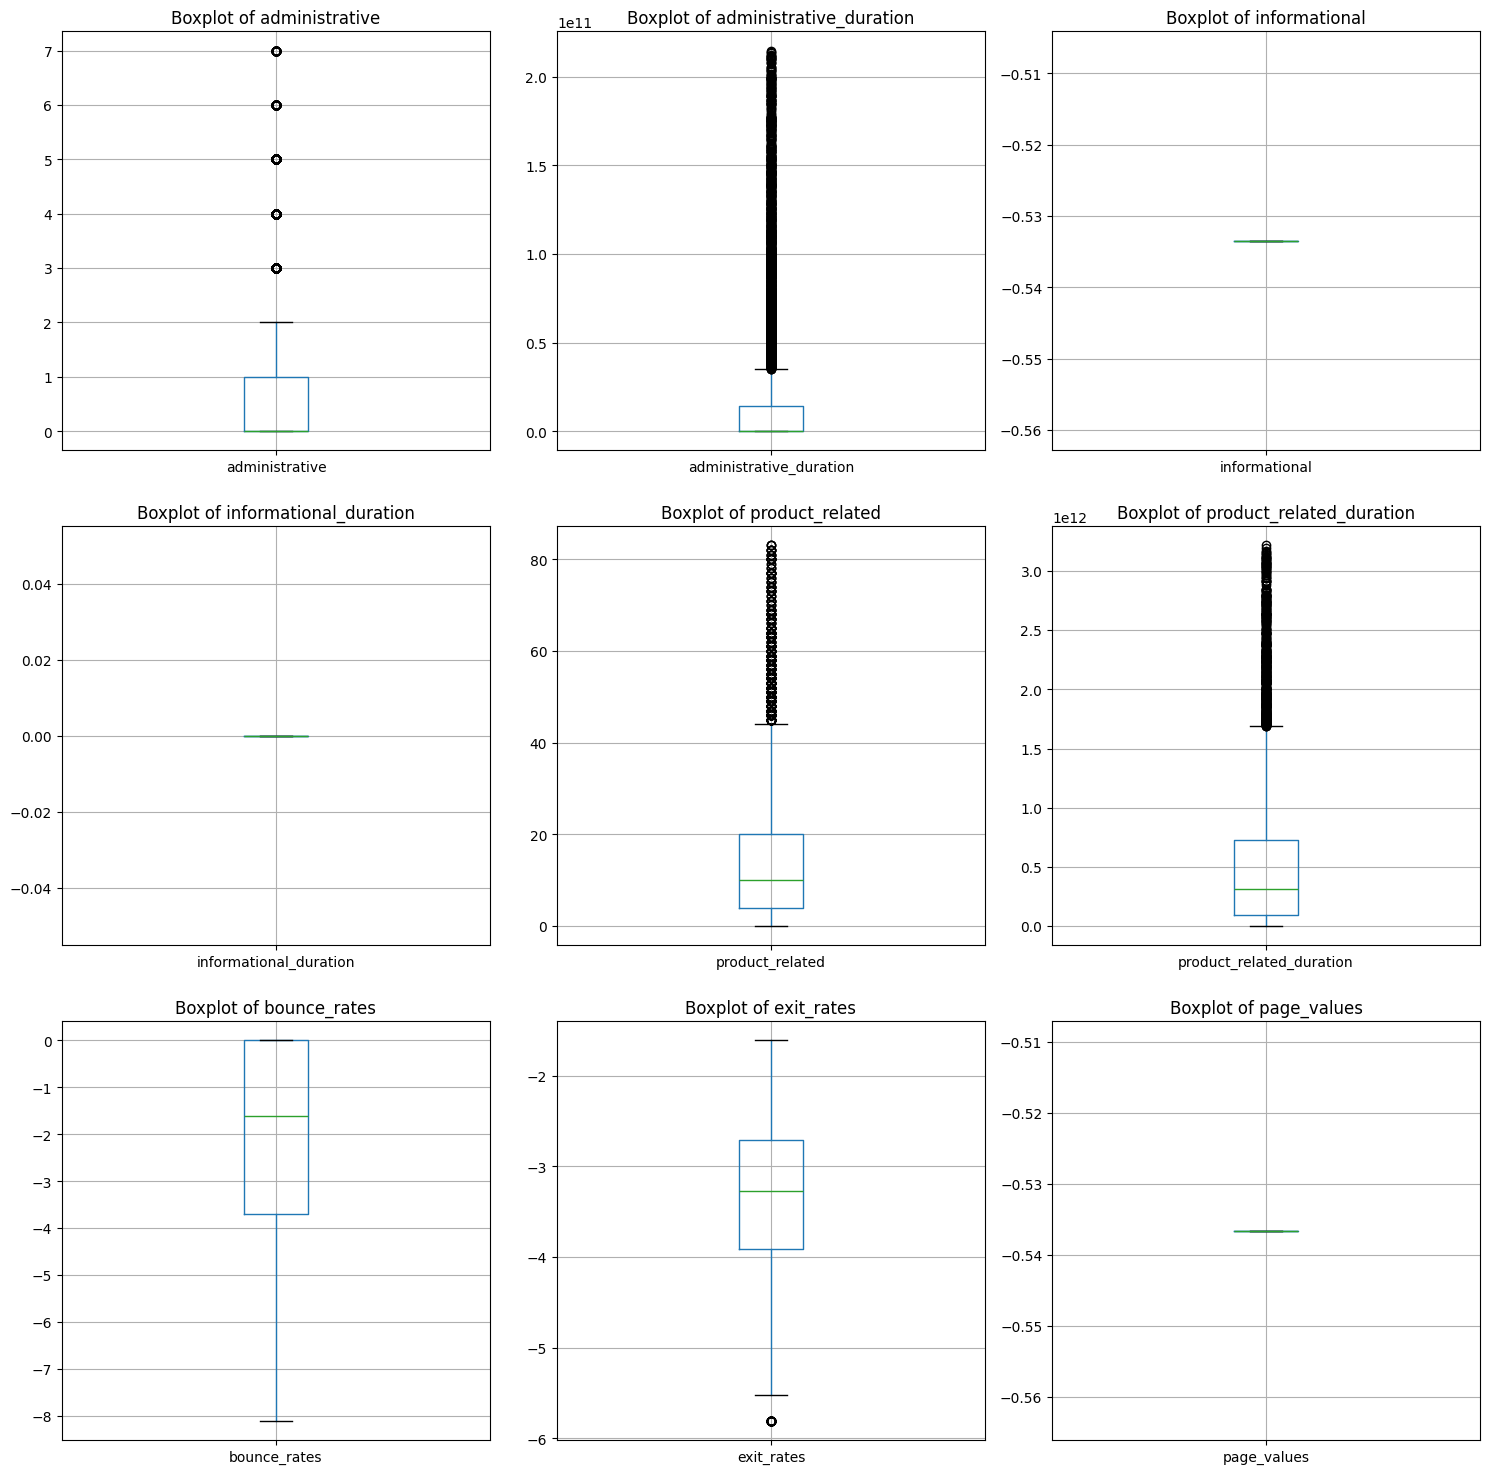

In [13]:
plotter_5=Plotter()
revisualised_data=plotter_5.visualise_outliers(df_cleaned,columns=['administrative','administrative_duration','informational','informational_duration','product_related','product_related_duration','bounce_rates','exit_rates','page_values'])

As can be seen from the boxplots, all the relevant outliers have been removed from the dataset

## Dropping Overly Correlated Columns

Highly correlated columns in a dataset can lead to multicollinearity issues, which can affect the accuracy and interpretability of models built on the data. This stage of analysis will identify any highly correlated columns and remove them to improve the quality of the data.

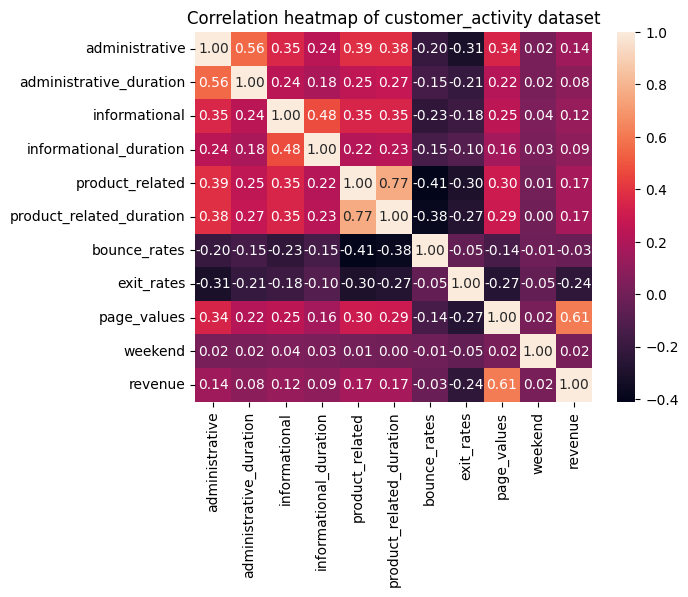

In [14]:
import importlib
import transformations
importlib.reload(transformations)
from transformations import Plotter
plotter_6=Plotter()
corr_heatmap=plotter_6.create_heatmap(df)



A good rule of thumb is to only think about removing any variabes if the absoulute value of the correlation coefficient between any of them is above 0.9. Looking at the heatmap above, the highest correlation is between 'revenue' and 'page_values'. As this is only 0.61, these columns wouldn't be considered overly correlated so there is no need to remove any of them.